<span style="color: green; font-size: 40px; font-weight: bold;">Lab 5 (Clusterização (Agrupamento)) </span>

<br> <br>

# Agrupando Veículos Por Similaridade

<br>

### Contexto

Neste projeto, abordaremos uma aplicação prática de técnicas de aprendizado não supervisionado, especificamente a **clusterização de veículos** com base em suas características. Diferente de problemas supervisionados, onde as respostas corretas são conhecidas e usadas para treinar o modelo, aqui o objetivo é descobrir grupos naturais ou clusters nos dados. Através deste processo, pretendemos identificar padrões e agrupamentos de veículos que compartilham características similares, como tipo de combustível, número de portas, tipo de direção, potência, consumo de combustível, entre outros. Esta técnica é útil em diversos contextos, como segmentação de mercado, identificação de perfis de clientes, e análise de produtos.

<br>

### Objetivo

O objetivo deste projeto é **agrupar veículos em clusters com base em suas características similares**. Utilizando um algoritmo de aprendizado não supervisionado, como o K-means, o modelo analisará os dados de entrada e identificará grupos de veículos que compartilham características comuns, sem a necessidade de rótulos predefinidos.

<br>

### Pergunta de Negócio Principal

> "Como podemos agrupar veículos de acordo com suas características para identificar grupos de similaridade?"

<br>

### Entregável

O entregável deste projeto será uma **análise de agrupamento (clusterização) de veículos**, onde veículos similares serão agrupados em clusters. Esses clusters podem ser usados para diversas finalidades, como identificar segmentos de mercado, definir estratégias de marketing ou até mesmo analisar padrões de fabricação e consumo. O projeto incluirá a preparação dos dados, a escolha do algoritmo de clusterização, a execução do modelo e a interpretação dos resultados.

<br>

### Sobre o Conjunto de Dados

Os dados utilizados neste projeto contêm várias características dos veículos, incluindo fabricante, tipo de combustível, número de portas, tipo de direção, número de cilindros, potência, consumo de combustível na cidade e na estrada, e preço. Estes atributos servirão como base para identificar similaridades e agrupar os veículos.

<br>

<table border="2">
  <tr>
    <th style="text-align: center; font-size: 16px;">Nome da Coluna</th>
    <th style="text-align: center; font-size: 16px;">Tipo de Dado</th>
    <th style="text-align: center; font-size: 16px;">Descrição</th>
  </tr>
  <tr>
    <td>fabricante</td>
    <td>string</td>
    <td>Nome do fabricante do veículo.</td>
  </tr>
  <tr>
    <td>tipo_combustivel</td>
    <td>string</td>
    <td>Tipo de combustível utilizado pelo veículo (gasolina, diesel, etc.).</td>
  </tr>
  <tr>
    <td>aspirado</td>
    <td>string</td>
    <td>Indicação se o motor é aspirado ou não.</td>
  </tr>
  <tr>
    <td>portas</td>
    <td>integer</td>
    <td>Número de portas do veículo.</td>
  </tr>
  <tr>
    <td>tipo</td>
    <td>string</td>
    <td>Tipo de carroceria do veículo (hatchback, sedan, etc.).</td>
  </tr>
  <tr>
    <td>direcao</td>
    <td>string</td>
    <td>Tipo de direção do veículo (traseira, dianteira, etc.).</td>
  </tr>
  <tr>
    <td>cilindros</td>
    <td>integer</td>
    <td>Número de cilindros do motor.</td>
  </tr>
  <tr>
    <td>horsepower</td>
    <td>integer</td>
    <td>Potência do motor, medida em cavalos de força.</td>
  </tr>
  <tr>
    <td>rpm</td>
    <td>integer</td>
    <td>Rotações por minuto (RPM) em que a potência máxima é alcançada.</td>
  </tr>
  <tr>
    <td>consumo_cidade</td>
    <td>integer</td>
    <td>Consumo de combustível na cidade (milhas por galão).</td>
  </tr>
  <tr>
    <td>consumo_estrada</td>
    <td>integer</td>
    <td>Consumo de combustível na estrada (milhas por galão).</td>
  </tr>
  <tr>
    <td>preco</td>
    <td>integer</td>
    <td>Preço do veículo em dólares.</td>
  </tr>
</table>

<br><br><br>

# Importando Pacotes

In [1]:
# Importa o findspark e inicializa
import findspark
findspark.init()

# Imports
import numpy as np
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
import matplotlib.pylab as plt
%matplotlib inline

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

<br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Preparando o Ambiente Spark</span>

In [2]:
# Definindo semente aleatória (seed) para reprodutibilidade do notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

# Se houver uma sessão Spark ativa, encerre-a
if 'sc' in globals():
    sc.stop()

if 'spark' in globals():
    spark.stop()


# Criando o Spark Context
conf = SparkConf().setAppName("Lab5") \
                  .set("spark.ui.showConsoleProgress", "false") \
                  .set("spark.executor.heartbeatInterval", "20s") \
                  .set("spark.eventLog.enabled", "false") \
                  .set("spark.sql.shuffle.partitions", "2") \
                  .set("spark.sql.debug.maxToStringFields", "100") \
                  .set("spark.executor.memory", "4g") \
                  .set("spark.driver.memory", "4g") \
                  .set("spark.driver.maxResultSize", "2g")  # Configuração adicional para limitar o tamanho do resultado

# Criar o Spark Context e a Spark Session
sc = SparkContext(conf=conf)
spSession = SparkSession.builder.config(conf=conf).getOrCreate()

# Ajustar o nível de log para ERROR
sc.setLogLevel("ERROR")

# Configurar log4j para suprimir avisos (deixar como comentário e volta ao normal)
log4j_logger = sc._jvm.org.apache.log4j
log4j_logger.LogManager.getLogger("org").setLevel(log4j_logger.Level.ERROR)
log4j_logger.LogManager.getLogger("akka").setLevel(log4j_logger.Level.ERROR)

# Visualizar o objeto spark_session
spSession

24/08/13 16:55:17 WARN Utils: Your hostname, eduardo-Inspiron-15-3520 resolves to a loopback address: 127.0.1.1; using 192.168.0.13 instead (on interface wlp0s20f3)
24/08/13 16:55:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/13 16:55:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/13 16:55:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Carregando os Dados</span>

- Os dados serão carregados a partir de um arquivo CSV e gerados como um RDD (Resilient Distributed Dataset) no Apache Spark. O RDD é uma estrutura de dados distribuída que permite o processamento paralelo em um cluster, otimizando a performance.

In [3]:
# Carregando os dados e gerando um RDD
carrosRDD = sc.textFile("Lab/dados/dataset5.csv")

# Tipo
print(type(carrosRDD), '\n')

# Colocando o RDD em cache. Esse processo otimiza a performance
print(carrosRDD.cache(), '\n')

# Número de registros
print(carrosRDD.count(), '\n')

<class 'pyspark.rdd.RDD'> 

Lab/dados/dataset5.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 

198 



In [4]:
# Visualizando as primeiras linhas
print(carrosRDD.take(5))

['fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco', 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118', 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151', 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195', 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']


In [5]:
## Visualizando primeiras 4 linhas com Pandas (Apenas para visualização)

import pandas as pd

# Obter as primeiras 5 linhas do RDD
linhas = carrosRDD.take(5)

# Separar as colunas da primeira linha
colunas = linhas[0].split(",")

# Separar os dados das linhas seguintes, já que o delimitador é uma vírgula
dados_formatados = [linha.split(",") for linha in linhas[1:]]

# Criar um DataFrame Pandas usando as colunas e os dados formatados
df = pd.DataFrame(dados_formatados, columns=colunas)

# Mostrar o DataFrame
display(df)

,fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco
0,subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118
1,chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151
2,mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195
3,toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348


<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória Inicial dos Dados </span>

<br>

### Criação de Função Para Análise Inicial

In [6]:
import pandas as pd
import re

def funcao_analise_inicial(df):
    # Configurar Pandas para exibir todas as linhas
    pd.set_option('display.max_rows', None)

    # Informações do DataFrame
    print('\n\n INFO \n\n')
    df.info()
    print('\n\n ------------------------------------------------------------------------------------------ \n\n')

    # Verifica se há valores ausentes e duplicados
    valores_ausentes = df.isna().sum().sum() > 0
    valores_duplicados = df.duplicated().sum() > 0

    # Nomes das variáveis com valores ausentes
    variaveis_ausentes = df.columns[df.isna().any()].tolist()

    # Número de linhas duplicadas
    num_linhas_duplicadas = df.duplicated().sum()

    # Porcentagem de linhas duplicadas
    porcentagem_linhas_duplicadas = (num_linhas_duplicadas / len(df)) * 100

    # Exibe o resultado sobre valores ausentes e duplicados
    print("\n\nExistem valores ausentes:", valores_ausentes)
    if valores_ausentes:
        print("\nVariáveis com valores ausentes:", variaveis_ausentes)
    else:
        print("\nNenhuma variável possui valores ausentes.")

    print("\n\nExistem valores duplicados:", valores_duplicados)
    if valores_duplicados:
        print("\nNúmero de Linhas Duplicadas:", num_linhas_duplicadas)
        print("\nPorcentagem de Linhas Duplicadas: {:.2f}%".format(porcentagem_linhas_duplicadas))
    else:
        print("\nNenhuma variável possui valores duplicados.")
    
    # Verificação de caracteres especiais
    caracteres_especiais = re.compile('[@_!#$%^&*<>()?/\\|}{~:]')   # nenhum caracter removido
    colunas_com_caracteres_especiais = {}

    for coluna in df.columns:
        if df[coluna].dtype == 'object':  # Verifica apenas colunas de texto
            contem_caracteres_especiais = df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False)).any()
            if contem_caracteres_especiais:
                indices_com_caracteres_especiais = df[coluna][df[coluna].apply(lambda x: bool(caracteres_especiais.search(x) if isinstance(x, str) else False))].index.tolist()
                colunas_com_caracteres_especiais[coluna] = indices_com_caracteres_especiais

    # Exibe o resultado sobre caracteres especiais
    print("\n\nExistem caracteres especiais nas colunas:", bool(colunas_com_caracteres_especiais))
    if colunas_com_caracteres_especiais:
        print("\nColunas com caracteres especiais e os índices:")
        for coluna, indices in colunas_com_caracteres_especiais.items():
            print(f"\n Coluna [ {coluna} ]: Índices com caracteres especiais {indices}")
    else:
        print("\nNenhuma coluna possui caracteres especiais.")

print('A função foi criada com sucesso.')

A função foi criada com sucesso.


<br>

### Transformando dados carregados em RDD para dataframe do Pandas (apenas para Análise Inicial)

- Vamos realizar análise exploratória através da função acima. RDDs são ótimos para processamento, mas ruins para exploração, então converteremos o RDD para DataFrame Spark e então para DataFrame Pandas (**não é possível converter diretamente objeto RDD para objeto Pandas**).

In [7]:
# Obter todas as linhas do RDD
linhas = carrosRDD.collect()

# Separar as colunas da primeira linha (cabeçalho)
colunas = linhas[0].split(",")

# Separar os dados das linhas seguintes
dados_formatados = [linha.split(",") for linha in linhas[1:]]

# Criar um DataFrame Pandas usando as colunas e os dados formatados
df_pandas = pd.DataFrame(dados_formatados, columns=colunas)

# Mostrar o DataFrame completo
display(df_pandas.head(10))

,fabricante,tipo_combustivel,aspirado,portas,tipo,direcao,cilindros,horsepower,rpm,consumo_cidade,consumo_estrada,preco
0,subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118
1,chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151
2,mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195
3,toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348
4,mitsubishi,gas,std,two,hatchback,fwd,four,68,5500,37,41,5389
5,honda,gas,std,two,hatchback,fwd,four,60,5500,38,42,5399
6,nissan,gas,std,two,sedan,fwd,four,69,5200,31,37,5499
7,dodge,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572
8,plymouth,gas,std,two,hatchback,fwd,four,68,5500,37,41,5572
9,mazda,gas,std,two,hatchback,fwd,four,68,5000,31,38,6095


<br>

### Visualizando Função para Análise Inicial

In [8]:
funcao_analise_inicial(df_pandas)



 INFO 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   fabricante        197 non-null    object
 1   tipo_combustivel  197 non-null    object
 2   aspirado          197 non-null    object
 3   portas            197 non-null    object
 4   tipo              197 non-null    object
 5   direcao           197 non-null    object
 6   cilindros         197 non-null    object
 7   horsepower        197 non-null    object
 8   rpm               197 non-null    object
 9   consumo_cidade    197 non-null    object
 10  consumo_estrada   197 non-null    object
 11  preco             197 non-null    object
dtypes: object(12)
memory usage: 18.6+ KB


 ------------------------------------------------------------------------------------------ 




Existem valores ausentes: False

Nenhuma variável possui valores ausentes.


Existem valores duplic

### Resumo

- Não será necessário nenhum tratamento de **Limpeza de Dados**.

<br> <br> <br>

### Resumo

- Necessário tratamento para conversão para tipo numérico das duas colunas.

<br> <br> <br>

# <span style="color: green; font-size: 38px; font-weight: bold;">Transformação dos Dados</span>

<br>

Nesta etapa trataremos aplicaremos técnica de Label_Encoding, conversão e exclusão de colunas.

<br>

## Criando Função para...

#### Colunas convertidas para valor numérico usando label encoding:

- **DOORS**: "two" → 1.0, qualquer outro valor → 2.0
- **BODY**: "sedan" → 1.0, qualquer outro valor → 2.0

#### Colunas que foram apenas convertidas para float:

- **HP**: Potência do carro (horsepower)
- **RPM**: Rotação por minuto (rpm)
- **MPG**: Milhagem (milhas por galão)

#### Colunas excluídas:

Todas as demais colunas do conjunto de dados original que não foram mencionadas acima.

<br>

#### Importante
> O cabeçalho precisa ser removido no objeto RDD porque interferiria no processamento numérico subsequente, onde cada linha esperava receber dados numéricos e categóricos para serem transformados e convertidos em um formato específico.

<br>

#### Criando e Aplicando a Função (diretamente no objeto RDD)

In [9]:
# Removendo a primeira linha do arquivo (cabeçalho)
primeiraLinha = carrosRDD.first()
carrosRDD2 = carrosRDD.filter(lambda x: x != primeiraLinha)
carrosRDD2.count()

# Convertendo e limpando os dados
def transformToNumeric(inputStr) :
    
    # Divide a linha em colunas
    attList = inputStr.split(",")

    # Aplica label encoding para as colunas de índice 3 e 4
    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    # Selecionando e convertendo somente algumas variáveis do conjunto de dados original
    linhas = Row(DOORS = doors, 
                 BODY = float(body), 
                 HP = float(attList[7]), 
                 RPM = float(attList[8]),
                 MPG = float(attList[9]))
    return linhas

# Aplicando a função
carrosRDD3 = carrosRDD2.map(transformToNumeric)

# Visualiza primeiras linhas
carrosRDD3.take(5)

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0)]

<br><br><br>

# <span style="color: green; font-size: 38px; font-weight: bold;"> Análise Exploratória</span>

<br>

- Realizando uma nova etapa de <i>Análise Exploratória</i> agora com os dados já <i>tratados</i>.

<br>

#### Convertendo Para Dataframe do Pyspark

In [10]:
# Transforma para DataFrame
carrosDF = spSession.createDataFrame(carrosRDD3)
print(type(carrosDF))

# Exibir a estrutura do DataFrame para confirmação
print(carrosDF.printSchema())

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- DOORS: double (nullable = true)
 |-- BODY: double (nullable = true)
 |-- HP: double (nullable = true)
 |-- RPM: double (nullable = true)
 |-- MPG: double (nullable = true)

None


In [11]:
# Verificando primeiras linhas
carrosDF.show(5)

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
+-----+----+----+------+----+
only showing top 5 rows



In [12]:
# Describe

# Estatística descritiva
summary_pandas = carrosDF.describe().toPandas()

# Configurar Pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)

# Visualizar o resumo estatístico no formato Pandas
display(summary_pandas)

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359884,37.63920534951835,481.03591405011446,6.437862917085912
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


<br><br><br><br>

# Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

- O objeto já foi convertido para dataframe do pyspark na etapa anterior (carrosDF).

<br><br>

## Padronizando e Aplicando Técnica de DenseVector

- Nesta etapa, o objetivo é padronizar os dados numéricos e criar um vetor de características (`DenseVector`) que será usado na construção de modelos de machine learning. A padronização envolve centralizar os dados (subtraindo a média) e escalá-los (dividindo pelo desvio padrão), o que garante que todas as variáveis sejam tratadas na mesma escala.

<br>

#### Salvando média e o desvio padrão

> Os valores calculados são armazenados em variáveis do tipo Broadcast, o que permite que essas informações estejam disponíveis em todo o cluster do Spark.

In [13]:
# Extraindo a média e o desvio padrão
medias = summary_pandas.iloc[1,1:6].values.tolist()
desvios = summary_pandas.iloc[2,1:6].values.tolist()

# Colocando a média e o desvio padrão em variáves do tipo Broadcast (disponíveis em todo o cluster)
bc_media = sc.broadcast(medias)
bc_desvio = sc.broadcast(desvios)

print(medias)

['1.5685279187817258', '1.532994923857868', '103.60406091370558', '5118.0203045685275', '25.15228426395939']


<br>

#### Criando e Aplicando a Função Para Centralizar e Aplicar Escala Aos Dados (gerando um vetor de saída)

In [14]:
# Cada valor será subtraído da média e então dividido pelo desvio padrão.
def centerAndScale(inRow):
    
    # Variáveis globais
    global bc_media
    global bc_desvio
    
    # Array de médias e desvios
    meanArray = bc_media.value
    stdArray = bc_desvio.value

    # Array para o resultado
    retArray = []
    
    # Loop para o cálculo
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) / float(stdArray[i]) )
        
    return Vectors.dense(retArray)

# Aplica a função
carrosRDD4 = carrosDF.rdd.map(centerAndScale)

# Visualiza primeiras linhas
carrosRDD4.take(5)

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532, 0.9083]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375, 3.3936]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453, 0.753]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611, 1.5297]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941, 1.8403])]

<br>

# Convertendo Para Objeto Dataframe PySpark

- Transformar o RDD em um DataFrame do PySpark para facilitar a aplicação de técnicas de Machine Learning.

> Essa conversão é essencial para utilizar os métodos e algoritmos de Machine Learning disponíveis no PySpark.

#### Estrutura do DataFrame

- **features**: Um vetor denso contendo os valores padronizados das variáveis preditoras. Cada linha do DataFrame possui uma coluna features que armazena esse vetor.

#### Nota sobre o nome 'features':

> O nome 'features' é uma convenção comum em bibliotecas de Machine Learning, especialmente no PySpark. A coluna features contém todas as variáveis preditoras em um único vetor, o que facilita a aplicação de algoritmos de Machine Learning que esperam receber as variáveis preditoras encapsuladas em uma única coluna de vetores.

<br>

#### Converte o objeto RDD para um DataFrame do Spark

In [15]:
# Transformando e criando um Dataframe
carrosRDD5 = carrosRDD4.map(lambda f:Row(features = f))
carrosDF = spSession.createDataFrame(carrosRDD5)

# As primeiras 15 linhas do DataFrame são exibidas, mostrando o conteúdo da coluna features, que encapsula os
# valores padronizados das variáveis preditoras em cada linha.
carrosDF.select("features").show(15)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[0.86895117361793...|
|[0.86895117361793...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 15 rows



<br><br><br><br><br>

<span style="color: green; font-size: 40px; font-weight: bold;">Construindo Modelo de Machine Learning</span>

<br>
<br>
<br>

# Modelo K-Means

<br>

### Criação, Treinamento e Previsão

In [16]:
# Criando o modelo (valor ideal de k poderia ser criado através de um loop para verificar melhor valor)
kmeans = KMeans(k = 3, seed = 1)

# Treina o modelo
modelo = kmeans.fit(carrosDF)

# Previsões
previsoes = modelo.transform(carrosDF)
previsoes.show(15)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
|[0.86895117361793...|         1|
|[0.86895117361793...|         1|
|[-1.1449709581789...|         2|
|[-1.1449709581789...|         2|
+--------------------+----------+
only showing top 15 rows



<br>

## Extraindo e Formatando os Dados das Previsões

<br>

#### Criando função para extratir atributos das previsões

- A função `unstripData` irá extrair (descompactar) os dados contidos nas previsões, separando o valor do cluster (a que grupo o dado pertence) e os valores das variáveis (features) usadas para fazer essa previsão. Isso facilita a análise posterior desses dados.

In [23]:
# Cria a Função
def unstripData(instr) :
    return (instr["prediction"], 
            instr["features"][0], 
            instr["features"][1], 
            instr["features"][2], 
            instr["features"][3],
            instr["features"][4])

# Aplica a função 'unstripData' ao RDD de previsões para obter um RDD com as previsões e suas features separadas.
carrosRDD6 = previsoes.rdd.map(unstripData)

# Coleta os resultados do RDD transformado para uma lista.
predList = carrosRDD6.collect()

print("Processo executado com sucesso.")

Processo executado com sucesso.


<br>

#### Convertendo Para DataFrame Pandas

In [24]:
# Converte a lista de previsões e features em um DataFrame do Pandas para análise mais detalhada e visualização.
predPd = pd.DataFrame(predList)

# Renomeando as colunas do DataFrame Pandas
predPd.columns = ['Cluster', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']

# Visualiza as primeiras 10 linhas do DataFrame Pandas para inspecionar os dados.
predPd.head(10)

,Cluster,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5
0,2,-1.144971,0.933672,-0.919362,-0.453231,0.908332
1,2,-1.144971,0.933672,-1.477291,-0.037461,3.393629
2,2,-1.144971,0.933672,-0.945930,-0.245346,0.753001
3,2,-1.144971,0.933672,-1.105338,-0.661116,1.529656
4,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
5,2,-1.144971,0.933672,-1.158475,0.794077,1.995649
6,2,-1.144971,-1.065604,-0.919362,0.170423,0.908332
7,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
8,2,-1.144971,0.933672,-0.945930,0.794077,1.840318
9,2,-1.144971,0.933672,-0.945930,-0.245346,0.908332


A tabela mostra os clusters atribuídos a cada ponto de dado (coluna 0) e os valores das variáveis padronizadas (colunas 1 a 5) usadas no algoritmo K-Means para agrupar os dados.

<br>

#### Visualizando Através de Gráficos

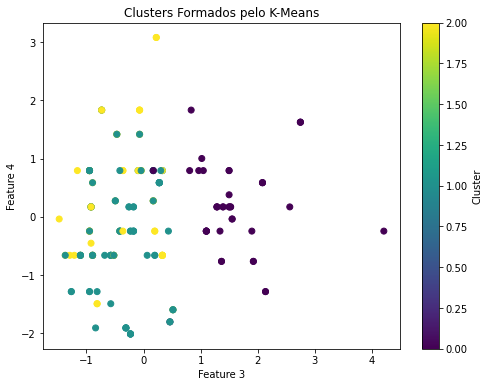

In [26]:
# Gráfico com o resultado dos clusters criados
plt.figure(figsize=(8, 6))
plt.scatter(predPd['Feature 3'], predPd['Feature 4'], c=predPd['Cluster'], cmap='viridis')
plt.title('Clusters Formados pelo K-Means')
plt.xlabel('Feature 3')
plt.ylabel('Feature 4')
plt.colorbar(label='Cluster')
plt.show()

### Explicando o Gráfico:

- **Eixos X e Y (Feature 3 e Feature 4)**: Representam duas das variáveis padronizadas que foram usadas para criar os clusters.
- **Cores**: As cores representam diferentes clusters. Cada cor indica um grupo distinto de pontos que o algoritmo K-Means considerou similares.
- **Título e Legenda**: O título e a legenda ajudam a identificar que o gráfico mostra os clusters formados pelo K-Means e que as cores correspondem aos diferentes clusters.

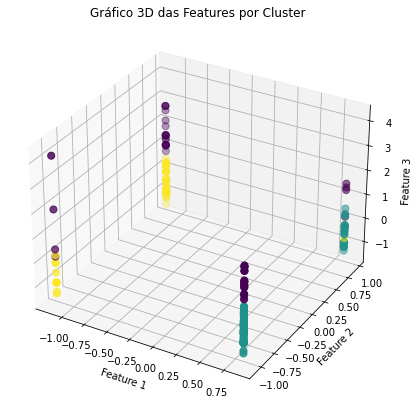

In [28]:
from mpl_toolkits.mplot3d import Axes3D

# Criando uma figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Gráfico 3D das primeiras três features
ax.scatter(predPd['Feature 1'], predPd['Feature 2'], predPd['Feature 3'], c=predPd['Cluster'], cmap='viridis', s=50)

# Definindo os rótulos dos eixos
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Título do gráfico
plt.title('Gráfico 3D das Features por Cluster')
plt.show()

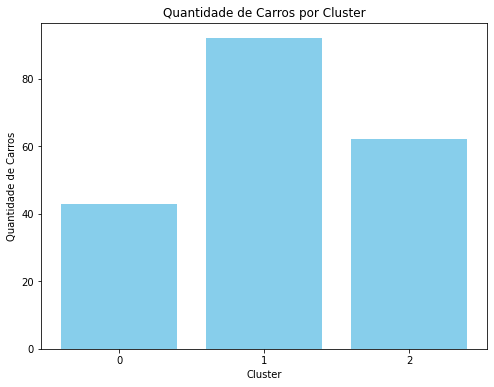

In [29]:
import matplotlib.pyplot as plt

# Contar o número de carros em cada cluster
cluster_counts = predPd['Cluster'].value_counts()

# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')
plt.title('Quantidade de Carros por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Quantidade de Carros')
plt.xticks(cluster_counts.index)  # Mostrar os rótulos dos clusters no eixo X
plt.show()

<br><br>

# Fim!